# Dataset Analysis and Preprocessing

This Notebook describes the process of cleaning up the dataset from 
[this Repository](https://github.com/docmarionum1/haikurnn) to use it in my own Project

In [2]:
with open("data/haikus.csv", "r") as infile:
    data = infile.read()

print("The dataset contains {} words and {} Haikus".format(len(data.split()), len(data.split('\n'))))
print("{} words are unique, thats about {}%".format(len(set(data.split())), 
                                                    round(100*len(set(data.split()))/len(data.split()), 2)))

The dataset contains 1678116 words and 143139 Haikus
229089 words are unique, thats about 13.0%


Let's, just for fun, look at the ten most common and least common words in the dataset.

In [3]:
from collections import Counter

word_counts = Counter(data.split())

print("The ten most common words are: {}".format(sorted(word_counts, key=word_counts.get, reverse=True)[:10]))
print("The ten least common words are: {}".format(sorted(word_counts, key=word_counts.get, reverse=True)[-10:]))

The ten most common words are: ['the', 'to', 'I', 'a', 'and', 'of', 'my', 'you', 'is', 'in']
The ten least common words are: ['snow,sballas,3,3,5', 'snow,sballas,3,3,4', 'ejection,u', 'approached,and', 'geese,faintly', 'strong,love', 'loveliness.,gutenberg,6,8,6', 'has,broken', 'ephesus,img2poems,7,8,7', 'with,ur']


While the most common words are about what you would expect from a text dataset, the least common words are almost
exclusively typos or the haiku source/the Syllable counter(e.g "img2poems,7,8,7"). If we want to use this dataset efficiently, we will have to remove the sources and syllable data and fix these obnoxious missing spaces after a comma. By introducing an alphabet which defines all the valid characters, we can also get rid of any special characters like _&_ or _#_ in the text. 

In [6]:
import string
alphabet = string.ascii_lowercase + " "

def cleanline(line):
	line = " ".join(line.split(",")[:3])	#only select the actual haiku part
	line = line.lower()	#remove uppercase letters
	line = "".join([char for char in line if char in alphabet])	#remove invalid chars
	line = " ".join(line.split())	#remove multiple whitespaces
	line = line.strip()
	return line

with open("data/haikus.csv", "r") as infile:
    lines = [cleanline(line) for line in infile.readlines()]

#count word occurences again
word_counts = Counter(" ".join(lines).split())

print("The ten most common words are: {}".format(sorted(word_counts, key=word_counts.get, reverse=True)[:10]))
print("The ten least common words are: {}".format(sorted(word_counts, key=word_counts.get, reverse=True)[-10:]))

The ten most common words are: ['the', 'i', 'to', 'a', 'and', 'you', 'of', 'my', 'is', 'in']
The ten least common words are: ['queensborough', 'moguls', 'xenon', 'interventionists', 'fleeced', 'sheri', 'sherk', 'mossscalloped', 'hashimoto', 'untalented']


The typos seem to be mostly gone and the least common words also seem about right now. Lets see how that 
reduced our number of tokens.

In [7]:
print("The cleaned dataset contains {} unique words".format(len(word_counts)))

The cleaned dataset contains 42938 unique words


43k words is already far better than 230k but its still far beyond my Model's capabilities. Ideally, we want to
shrink the number of unique words(tokens) to around 10k or lower to keep training times feasible. It quickly becomes apparent that we might not be able to use the entirety of the dataset.(Lets ignore Haikus that dont fit
the 5-7-5 syllable criteria). Filtering out all the haikus that contain words whose number of occurences falls below a certain threshold should reduce the number of unique tokens while still keeping a reasonable number of Haikus.

In [8]:
#my occurence threshold is arbitrary, i only chose it because it results in around 8k unique tokens left
min_occurences = 12
result = []

for line in lines:
    for word in line.split():
        if word_counts[word] < min_occurences:
            break
    else:
        result.append(line + " <eos>\n")
        
print("{} unique Tokens left".format(len(set(" ".join(result).split()))))

8212 unique Tokens left


To use a batch size larger than 1, the samples need to be padded to the same length. This is easier if the haikus all have more or less the same length. Since most of the Haikus probably already are pretty similar in length, it is possible to just delete Haikus with a length below/above a certain threshold.

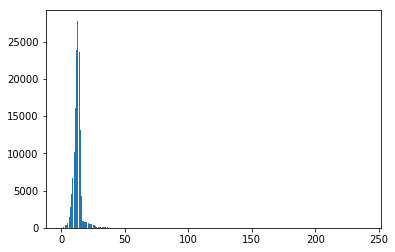

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

lengths = [len(line.split()) for line in lines]
counter = Counter(lengths)
occurences = [counter[key] for key in counter.keys()]
plt.bar(x=list(counter.keys()), height=occurences)
plt.show()

Based on the bar graph above, i chose 12 as the minimum length and 15 as the maximum length

In [14]:
cut_lines = []
for line in lines:
    if 12 <= len(line.split()) <= 15:
        cut_lines.append(line)
lines = cut_lines

['a sunny day pink haze of the cherry blossoms over the hill', 'orange sunrise peaks through the tubes and wires of fathers life support machine', 'in winters wind the call of a friend who now has cancer', 'last red in the sky a small girls moon face rises over the counter', 'day moon the woman with silver hair steps back into the shade', 'late night at the office an exit sign floats next to the moon', 'lingering cold the last jar of maple syrup on the cupboard shelf', 'working late the sound of a small brown moth in the lampshade', 'too hot to sleep i search for my sons footprint in the front drive', 'the boat crests a wave tracing my finger around an ancient stone']


The basic preprocessing is done now but you might want to add a profanity filter and check for swearing words in
the dataset. After all, the vast majority of the Haikus comes from Twitter([#Twaiku](https://twitter.com/hashtag/Twaiku)), meaning that some of them are a bit ... 'special'. Note that checking every single Haiku for bad words takes quite a while. You might want to do this outside of a notebook.

In [ ]:
import spacy
from profanity_filter import ProfanityFilter

#swear filter
nlp = spacy.load("en_core_web_sm")
profanity_filter = ProfanityFilter(nlps={'en': nlp})
nlp.add_pipe(profanity_filter.spacy_component, last=True)

#my occurence threshold is arbitrary, i only chose it because it results in around 8k unique tokens left
min_occurences = 12
contains_rare = 0
result = []

for line in lines:
	for word in line.split():
		if occurences[word] < min_occurences:
			contains_rare += 1
			break
	else:
		if not nlp(line)._.is_profane:
			result.append(line + " <eos>\n")

Now that we have the final collection of all the Haikus we can save the to a file and train our model on them!

In [9]:
with open("data/dataset_clean.txt", "w") as outfile:
    outfile.writelines(result)